In [1]:
import sys
import os
from os import path
from datetime import date
import math
import warnings
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from plotnine import *
from scipy import stats
from scipy.stats import linregress
import gspread
from mizani.formatters import scientific_format
from mizani.breaks import date_breaks
from mizani.formatters import date_format
import warnings

%matplotlib inline

import skmisc
import outliers
from outliers import smirnov_grubbs as grubbs

# read in custom modules
sys.path.append('/Users/rosekantor/work/wbe_data_analysis/')

from read_gsheets import * 
from reprocess_qpcr import *
from calculations import *
from qa_qc import *
from quality_score import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Data tables:
* plate_df: contains raw qPCR data
* qpcr_processed: contains processed qPCR data (one row for each Sample x Target)
* sample_data: contains sample_inventory (one row for each Sample)
* site_data: contains info about sampling sites, one row for each site
* plate_target_info: contains info about standard curves, LoD, LoQ, date run, etc. for each plate x Target
* sample_data_qpcr: all tables merged for visualizations

to calculate quality score, sample_data and plate_target_info need to be merged

# TODO
* DONE---clean read_gsheets.py and allow files or urls
* DONE---change negative control data storage to 2-column format (T/F and value)
* DONE---make test files and write tests for process_qpcr_raw (reprocess_qpcr.py) - now obsolete, need to remake
* DONE---clean combine_triplicates
* DONE---clean process_standard
* DONE---clean process_unknown
* DONE---clean determine_BLoQ
* DONE---clean determine_BLoD - this doesn't exist
* DONE---clean process_dilutions
* DONE---clean xeno inhibition functions
* clean calculations.py
* check lengths of all dfs after each step to make sure samples don't get lost, after data is clean, use "validate" option in pandas merge
* go back thru to determine which summary columns (e.g. Cq_init_min) are actually used by the code, have them get created in the function where they are used, not saved anywhere
* go back thru and figure out which std curve info is actually used, delete the rest
* check which modules are actually used, delete the rest
* clean qPCR data - delegate one-offs to lab team, code the systematic sample_id changes
* write more tests
* run tests

# Load files and process

In [2]:
sites = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/site_lookup_112420.csv'
samples = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/sample_inventory_112420.csv'
qpcr = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/QuantStudio_raw_data_112520.csv'
plates = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/Plate_info_112520.csv'

In [3]:
gc = None
url = None
rxn_volume = 20.0
template_volume = 5.0

plate_df = read_qpcr_data(gc, url, qpcr)
plate_df = plate_df[plate_df.plate_id >= 1000]
qpcr_processed_dilutions, plate_target_info = process_qpcr_plate(plate_df)


# merge plate data with data coming out of process_qpcr_plate
plate_info_df = pd.read_csv(plates)
plate_target_info = plate_target_info.merge(plate_info_df, how = 'left', on = 'plate_id')

# fill in default values
plate_target_info.loc[plate_target_info.rxn_volume.isna(), 'rxn_volume'] = rxn_volume
plate_target_info.loc[plate_target_info.template_volume.isna(), 'template_volume'] = template_volume

# process Xeno assay results to check for inhibition
qpcr_processed_dilutions_xeno = qpcr_processed_dilutions[qpcr_processed_dilutions.Target == 'Xeno']
df_xeno = []
for plate_id, df in qpcr_processed_dilutions_xeno.groupby('plate_id'):
    df_inhibition = process_xeno_inhibition(df, plate_target_info, plate_id)
    df_xeno.append(df_inhibition)
df_xeno = pd.concat(df_xeno)
qpcr_processed_dilutions = qpcr_processed_dilutions.merge(df_xeno, how='left', on=['Sample', 'dilution', 'plate_id'])
qpcr_processed_dilutions = qpcr_processed_dilutions[qpcr_processed_dilutions.Target != 'Xeno']

# process dilutions
qpcr_processed = choose_dilution(qpcr_processed_dilutions)

# merge with sample data and plate_target info
# merging is dangerous, extra rows can be introduced if the merge isn't exact (e.g. multiple identical entries- see warnings)
sample_data = read_sample_data(gc, url, samples, sites)
sample_data_qpcr = qpcr_processed.merge(sample_data, how = 'left', left_on = 'Sample', right_on = 'sample_id')
sample_data_qpcr = sample_data_qpcr.merge(plate_target_info, how = 'left', on = ['plate_id', 'Target'])

# pull out extraction controls and report them for each batch
sample_data_qpcr = get_extraction_control(sample_data_qpcr)

# calculate gc/L and N1:PMMoV
sample_data_qpcr['gc_per_L'] = calculate_gc_per_l(sample_data_qpcr) # get gc/L
sample_data_qpcr = normalize_to_pmmov(sample_data_qpcr)

# add quality scores
quality_scores = quality_score(sample_data_qpcr)
sample_data_qpcr = sample_data_qpcr.merge(quality_scores, how='left', on=['Sample', 'Target', 'plate_id'])

/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:304: UserWarning: Plate 1064 is missing NTC
/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:304: UserWarning: Plate 1064 is missing NTC
/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:415: UserWarning: Sample B_B_SQ_110720_2 x N1 has multiple entries with the same dilution factor in plates [1064, 1064, 1070]
/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:415: UserWarning: Sample D_SEP_NF_101520_1 x N1 has multiple entries with the same dilution factor in plates [1033, 1052]
/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:415: UserWarning: Sample D_SEP_NF_101520_2 x N1 has multiple entries with the same dilution factor in plates [1051, 1052]
/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:415: UserWarning: Sample D_SEP_NF_101520_3 x N1 has multiple entries with the same dilution factor in plates [1051, 1052]
/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:415: Us

In [8]:
sample_data_qpcr.head()

,Sample,dilution,Task,Cq,Quantity,is_undetermined,Cq_no_outliers,Cq_init_mean,Cq_init_std,Cq_init_min,replicate_init_count,Q_init_mean,Q_init_std,Cq_mean,Cq_std,replicate_count,nondetect_count,Quantity_mean,below_limit_of_quantification,plate_id,Target,xeno_dCt,is_inhibited,Quantity_mean_undiluted,new_sample_id,sample_id,batch,sample_code,date_sampling,replicate,date_extract,extracted_by,weight,bCov_spike_tube,GFP_spike_tube,processing_error,qPCR_batch,Storage_conditions,salted_before_freezing,date_frozen,elution_vol_ul,effective_vol_extracted_ml,weight_vol_extracted_ml,bCoV_spike_vol_ul,GFP_spike_vol_ul,time,storage_notes,utility_name,county,utility,facility,interceptor,sample_level,sampling_days,sampling_frequency_per_week,interceptor_full_name,interceptor_description,interceptor_start_date,interceptor_pretreatment,interceptor_region_served,interceptor_population_served,interceptor_general_flow_MGD,num_points,slope,intercept,r2,efficiency,loq_Cq,loq_Quantity,Cq_of_lowest_std_quantity,used_default_curve,intraassay_var,Cq_of_lowest_sample_quantity,ntc_is_neg,ntc_Cq,plate_file_name,added pop up lab samples,plate_date,assays,standard_batch,description,run_by,rxn_volume,template_volume,plate_notes,extraction_control_is_neg,extraction_control_Cq,gc_per_ul_input,gc_per_L,pmmov_mean,mean_normalized_to_pmmov,log10mean_normalized_to_log10pmmov,log10_mean_normalized_to_pmmov,score,flag,point_deduction,quality_score,detected_of_3_TechReps
0,J_UCV_082020_1,1,Unknown,"[26.400205800000002, 26.5121506, 26.5770239]","[185899.78, 173442.458, 166609.032]","[False, False, False]","[26.400205800000002, 26.5121506, 26.5770239]",26.496460,0.073033,26.400206,3,1.751369e+05,1.056987,26.496460,0.073033,3,0,1.673479e+05,False,1001,PMMoV,NaN,NaN,1.673479e+05,J_J_UCV_082020_1,J_UCV_082020_1,R08212001,J_J_UCV,2020-08-20,1,2020-08-21,NaN,63.485,N,NaN,NaN,"R2, R4",-80,1.0,8/21/20,200.0,40.0,40.000,50.0,20.0,NaN,NaN,UCB,Alameda,J,J,UCV,Residential,Thursday,3.0,University Village,University Village,NaN,NaN,NaN,NaN,NaN,7,-3.702956,45.839298,0.998855,0.862321,38.141236,100.0,38.141236,False,15.630451,30.240900,False,39.36129,R1_PMMoV_Test,Batch R1,9/18/20,PMMoV,NaN,Melissa's first plate,Melissa,20.0,5.0,previously called R1,None,NaN,3.346958e+04,1.673479e+08,167347.891598,1.000000,1.000000,0.000000,0.66,test for inhibition has not been performed; check extraction negative control,no-template qPCR control had low-level amplification,84.615385,3
1,B_SQ_082520_1,1,Unknown,"[13.183179999999998, 13.20534, 13.17878]","[191000000.0, 188000000.0, 191000000.0]","[False, False, False]","[13.183179999999998, 13.17878]",13.189100,0.011623,13.178780,3,1.899947e+08,1.009182,13.180980,0.002200,2,0,1.796845e+08,False,1004,GFP,NaN,NaN,1.796845e+08,B_B_SQ_082520_1,B_SQ_082520_1,R09032001,B_B_SQ,2020-08-25,1,2020-09-03,NaN,63.890,AC,I,NaN,"R2, R4",-80,1.0,9/3/20,200.0,40.0,40.405,50.0,20.0,23:45,left out over weekend,CMSA,Marin,B,B,SQ,Residential,"Saturday,Sunday,Monday,Tuesday",4.0,San Quentin Prison,NaN,NaN,NaN,NaN,NaN,NaN,7,-3.487499,41.968574,0.999880,0.935256,27.919310,10000.0,27.919310,False,5.195485,13.733743,True,NaN,R4_GFP_Routine9.22,some of batch R2 + spikes,9/22/20,GFP,NaN,Adrian training plate,Adrian,20.0,5.0,previously called R4,None,NaN,3.593690e+07,1.778834e+11,162166.703623,1108.023436,1.584371,3.044549,0.55,test for inhibition has not been performed; check extraction negative control,num tech reps = 2; hold time > 5 days,70.512821,3
2,D_OSP_090120_1,1,Unknown,"[12.34061, 12.391810000000001, 12.40912]","[334000000.0, 323000000.0, 319000000.0]","[False, False, False]","[12.34061, 12.391810000000001, 12.40912]",12.380513,0.029087,12.340610,3,3.252719e+08,1.024048,12.380513,0.029087,3,0,3.048142e+08,False,1004,GFP,NaN,NaN,3.048142e+08,D_OSP_INF_090120_1,D_OSP_090120_1,R09032001,D_OSP_INF,2020-09-01,1,2020-09-03,NaN,64.510,AC,I,NaN,"R2, R4",-80,1.0,9/1/20,200.0,40.0,41.025,50.0,20.0,NaN,NaN,SFPUC,SF,D,OSP,INF,Influent,Tuesday,1.0,Oceanside Treatment Plant Influent,O

In [7]:
plate_target_info[plate_target_info.Target == 'N1'].head()

,plate_id,Target,num_points,slope,intercept,r2,efficiency,loq_Cq,loq_Quantity,Cq_of_lowest_std_quantity,used_default_curve,intraassay_var,Cq_of_lowest_sample_quantity,ntc_is_neg,ntc_Cq,plate_file_name,added pop up lab samples,plate_date,assays,standard_batch,description,run_by,rxn_volume,template_volume,plate_notes
1,1002,N1,6,-3.474547,37.960298,0.993501,0.940025,33.991705,10.0,33.991705,False,223.926483,36.813555,True,NaN,R2_N1_RoutineSample9.21,Batch R2,9/21/20,"N1, xeno",1.1,High priority processed fresh,Melissa,20.0,5.0,previously called R2
5,1005,N1,5,-3.809679,39.868163,0.982627,0.830161,35.064931,10.0,35.064931,False,37.015142,36.425457,True,NaN,1005_N1_Routine9.18,Batch R5,9/23/20,"N1,xeno",1.1,Batch R5 routine samples processed 9/18/20 and 9/15/20; added controls,Melissa,20.0,5.0,NaN
10,1010,N1,5,-3.407526,39.277939,0.984526,0.965477,35.214617,10.0,35.214617,False,15.792568,37.917145,True,NaN,1010_N1_NursingHome_9.14-9.21redo,R6,9/28/20,"N1,xeno",1.1,"R6, inhibition testing of J_UCV_091720_1 redo",Melissa,20.0,5.0,redo of plate 1008
12,1011,N1,7,-3.715573,39.189552,0.997222,0.858393,36.864547,5.0,36.864547,False,54.797764,36.020096,True,NaN,1011_N1xeno_Routine9.29,R7,9/30/20,"N1,xeno",1.1,"R7, Routine samples processed 9/29/20",Melissa,20.0,5.0,NaN
15,1013,N1,7,-3.591556,38.840657,0.988237,0.898588,35.247422,5.0,35.247422,False,55.780515,37.460193,True,NaN,1013_N1xeno_Routine9.30,R8,10/1/20,"N1,xeno",1.1,"R8, Routine samples processed 9/30/20",Melissa,20.0,5.0,NaN


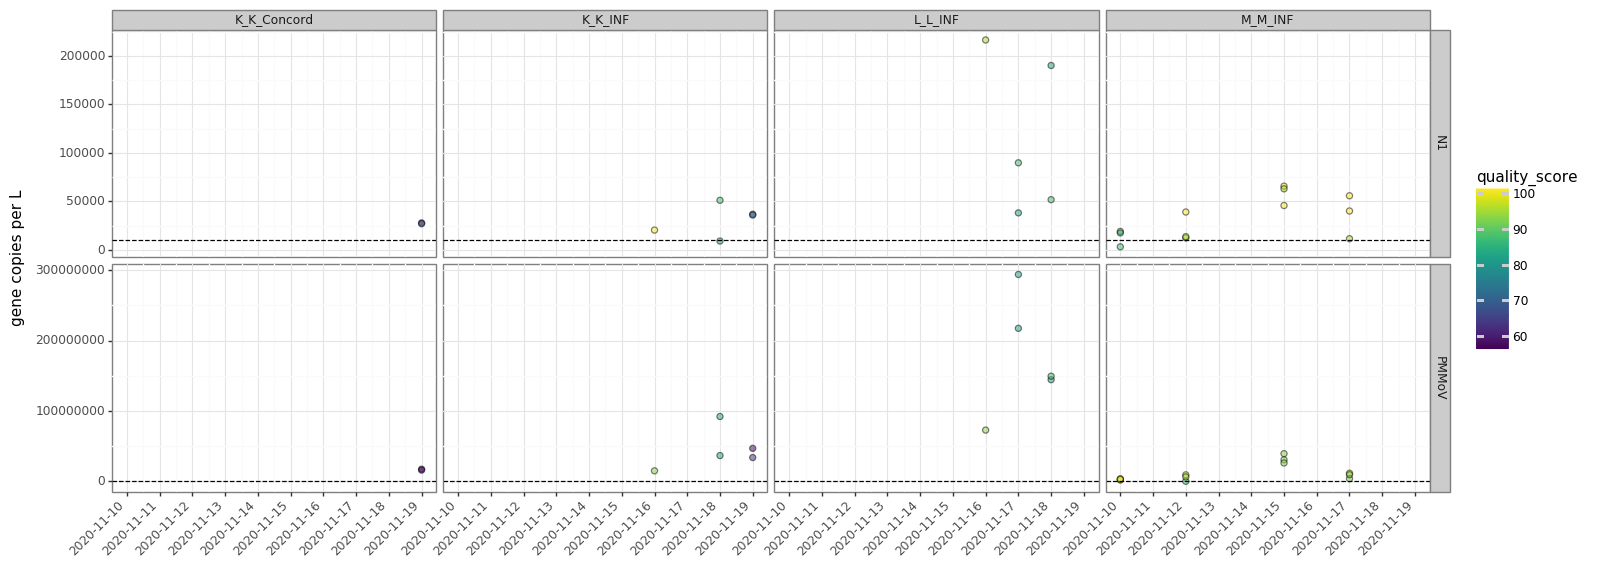

<ggplot: (301494245)>

In [6]:
# make column listing number of technical replicates detected, based on the non-detect count
sample_data_qpcr['detected_of_3_TechReps'] = 3 - sample_data_qpcr['nondetect_count']
# define all county dataframes
df_plotting = sample_data_qpcr[sample_data_qpcr.Target.isin(['N1', 'PMMoV'])].copy()
df_plotting = df_plotting[df_plotting.date_sampling > '2020-08-01']
df_plotting.nondetect_count = df_plotting.nondetect_count.astype('category') # convert to category so we can plot them by shape
df_plotting.detected_of_3_TechReps = df_plotting.detected_of_3_TechReps.astype('category') # convert to category so we can plot them by shape
contracosta = df_plotting[df_plotting.county == 'Contra Costa'].copy()

# N1 and PMMoV
plt = (ggplot(contracosta, aes(x='date_sampling', y='gc_per_L', fill='quality_score')) + 
geom_point(size=2, alpha=0.5)+
geom_abline(slope=0, intercept=10000, linetype='dashed')+
ylab('gene copies per L\n\n')+
xlab("")+
#scale_x_datetime(breaks = sf[sf.sample_code == 'D_OSP_INF'].date_sampling.unique(), labels = date_format('%D'))+
facet_grid('Target ~ sample_code', scales='free_y')+ #, 
theme_bw()+ theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(17,6)) )

display(plt)

# Checking for missing values to clean data

In [14]:
missing_date_sampling = sample_data[(sample_data.sample_id != '__') &
                                    (~sample_data.sample_id.str.contains('control')) &
                                    (np.isnat(sample_data.date_sampling))]
missing_date_extract = sample_data[(sample_data.sample_id != '__') &
                                    (~sample_data.sample_id.str.contains('control')) &
                                    (np.isnat(sample_data.date_extract))]
len(missing_date_sampling)
len(missing_date_extract) # These samples are the wastewater archive (or samples yet to be extracted)

686

In [55]:
sample_data_qpcr = qpcr_processed.merge(sample_data, how = 'left', left_on = 'Sample', right_on = 'sample_id')
# check for samples that are present in qpcr_processed but not in sample_data
missing = set(qpcr_processed.Sample) - set(sample_data.sample_id)
# check for samples that are present in sample_data but not in qpcr_processed (for N1 and PMMoV)
# set(sample_data.sample_id) - set(qpcr_processed.Sample)

# len(set(qpcr_processed.Sample))
# len(sample_data[~sample_data.date_extract.isna()].sample_id)
for i in missing:
    print(i)

D_SEP_CH_090320_1
control_spike_bCoV_123099_AE
D_SEP_Koret_111220_1
J_J_Kerr_111920_3
B_B_SQ_090120_1
D_SEP_Koret_102920
D_SEP_Koret_092420_2
D_SEP_INF_090820_1
D_Koret_091720_3
J_J_Kerr_111920_1
D_SEP_Koret_102920_1
D_SEP_Koret_110520_1
D_OSP_INF_090120_1
D_SEP_Koret_100120_1
D_SEP_NF_091020_1
D_SEP_CH_091020_1
J_J_Kerr_111920_2
L_L_INF_111720_2
D_SEP_Koret_101520_1
J_PC_072920_2
D_SEP_NS_090320_1
control_control_PBS_111920_2
control_control_PBS_110120_1
D_SEP_Koret_102220_1
control_spike_bCoV_123099_AC
NTC
D_SEP_INF_102920_1
D_SEP_Koret_092420_3
control_spike_bCoV_123099_AK
D_SEP_Koret_100820_1
D_Koret_091720_1
B_B_SQ_082520_1
D_SEP_Koret_092420_1
L_L_INF_111720_1
D_SEP_SEP011_090120_1
D_SEP_NS_091020_1
D_SEP_NF_090320_1
D_OSP_INF_090820_1
D_NF_101520_1
J_PC_072920_1
D_Koret_091720_2
D_SEP_INF_090120_1


# old tests

In [5]:
def test_process_qpcr_raw():
    # read in test plate and process
    test_in = pd.read_csv('/Users/rosekantor/work/wbe_data_analysis/test_qpcr_processed_testplate.csv')
    qpcr_processed, std_curve_df, dilution_expts_df,raw_outliers_flagged_df = process_qpcr_raw(test_in)

    # modify to match the expected saved test output
    qpcr_processed = qpcr_processed.round(2)
    qpcr_processed = qpcr_processed.reset_index().drop(columns = 'index')
    qpcr_processed.bloq = qpcr_processed.bloq.astype('bool')
    #qpcr_processed.to_csv('/Users/rosekantor/work/wbe_data_analysis/test_qpcr_processed_out.csv', index=False)

    # read in saved processed result, compare to processed result
    test_out = pd.read_csv('/Users/rosekantor/work/wbe_data_analysis/test_qpcr_processed_out.csv')
    assert test_out.equals(qpcr_processed)
test_process_qpcr_raw()

In [ ]:
# calculations
qpcr_averaged['gc_per_L'] = calculate_gc_per_l(qpcr_averaged) # get gc/L
qpcr_normd = normalize_to_pmmov(qpcr_averaged)

# convert true non-detects (all triplicates were undetermined) to near-zeros (can change to exact zero, but having a small number might help with plotting)
qpcr_normd.loc[qpcr_normd.is_undetermined_count == 3,"mean_normalized_to_pmmov"] = 0
qpcr_normd.loc[qpcr_normd.is_undetermined_count == 3,"gc_per_L"] = 0

# make 'PBS_result' column and remove extraction controls from main dataset
qpcr_normd = get_extraction_control(qpcr_normd)

#qpcr_normd = get_GFP_recovery(qpcr_normd) # this converts dates to numeric somehow

# test inhibition
qpcr_normd, xeno_inhib_full,xeno_control=xeno_inhibition_test(raw_outliers_flagged_df,qpcr_normd)
xeno_inhib=xeno_inhib_full.merge(sample_data, left_on='Sample', right_on='sample_id',  how='left').copy()

# filter out some bad data
qpcr_normd = qpcr_normd[qpcr_normd.date_sampling != '2020-07-28'] # samples were bleached during extraction on this date
qpcr_normd = qpcr_normd[qpcr_normd.plate_id != 1052] # this is the same plate as 1051 but with DNA standards

# convert to datetime (necessary to calculate hold times, read in as string because of "unk" values)
qpcr_normd.loc[qpcr_normd.date_extract == 'unk', 'date_extract'] = np.nan
qpcr_normd.date_extract = pd.to_datetime(qpcr_normd.date_extract)